### Convex optimization with CVXPY for Wigner state reconstructions

In [1]:
import numpy as np

from jax import numpy as jnp
from jax import jit, vmap
from jax import config


import cvxpy as cp

from qutip import coherent, coherent_dm, ket2dm, Qobj, fock, displace, fock_dm, expect, fidelity, thermal_dm
from qutip.visualization import plot_wigner_fock_distribution
from qutip.wigner import wigner, qfunc
from qutip.random_objects import rand_ket, rand_dm

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors

config.update("jax_enable_x64", True) # We want float64 for better precision

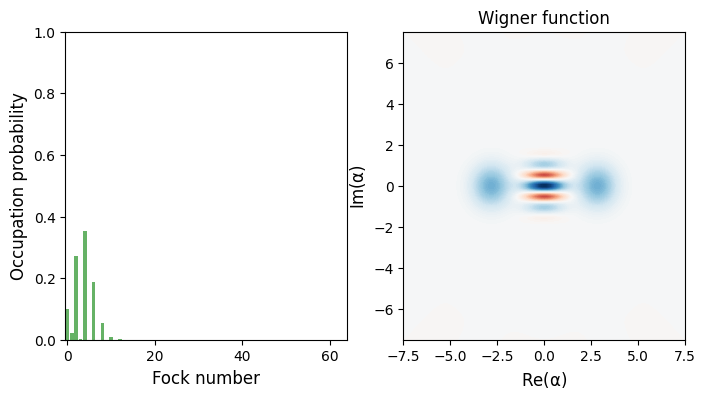

In [2]:
N = 64

# inspired by https://arxiv.org/pdf/2106.10655.pdf #

# define state

alpha_range = 2
alphas = np.array([alpha_range, -alpha_range]) #  - 1j*alpha_range, -alpha_range + 1j*alpha_range

psi = sum([coherent(N, a) for a in alphas])
psi = psi.unit()
rho = (psi*psi.dag())

p = 0.9
rho = p*rho + (1 - p)*thermal_dm(N, .5)
rho = rho.unit()

plot_wigner_fock_distribution(rho)
plt.show()

In [3]:
##################################
# construct operator basis (Fock basis)

basis_vectors = []

for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
#print(basis_vectors, "\n")

basis_dms = []

for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

In [4]:
basis_dms = jnp.array(basis_dms)

In [5]:
def dag(state):
    r"""Returns conjugate transpose of a given state, represented by :math:`A^{\dagger}`, where :math:`A` is
    a quantum state represented by a ket, a bra or, more generally, a density matrix.
    Args:
        state (:obj:`jnp.ndarray`): State to perform the dagger operation on
     
    Returns:
        :obj:`jnp.ndarray`: Conjugate transposed jax.numpy representation of the input state
 
    """
    return jnp.conjugate(jnp.transpose(state))


def _kth_diag_indices(a, k):
    rows, cols = jnp.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols


class Displace:
    r"""Displacement operator for optical phase space.
    
    .. math:: D(\alpha) = \exp(\alpha a^\dagger -\alpha^* a)
    Args:
    n (int): dimension of the displace operator
    """

    def __init__(self, n):
        # The off-diagonal of the real-symmetric similar matrix T.
        sym = (2.0 * (jnp.arange(1, n) % 2) - 1) * jnp.sqrt(jnp.arange(1, n))
        # Solve the eigensystem.
        mat = jnp.zeros((n, n), dtype=jnp.complex128)

        i, j = _kth_diag_indices(mat, -1)
        mat = mat.at[i, j].set(sym)

        i, j = _kth_diag_indices(mat, 1)
        mat = mat.at[i, j].set(sym)

        self.evals, self.evecs = jnp.linalg.eigh(mat)
        self.range = jnp.arange(n)
        self.t_scale = 1j ** (self.range % 2)

    def __call__(self, alpha):
        r"""Callable with ``alpha`` as the displacement parameter
        Args:
            alpha (float): Displacement parameter
        Returns:
            :obj:`jnp.ndarray`: Matrix representing :math:`n-`dimensional displace operator
            with :math:`\alpha` displacement
        
        """
        # Diagonal of the transformation matrix P, and apply to eigenvectors.
        transform = jnp.where(
            alpha == 0,
            self.t_scale,
            self.t_scale * (alpha / jnp.abs(alpha)) ** -self.range,
        )
        evecs = transform[:, None] * self.evecs
        # Get the exponentiated diagonal.
        diag = jnp.exp(1j * jnp.abs(alpha) * self.evals)
        return jnp.conj(evecs) @ (diag[:, None] * evecs.T)






hilbert_size = N
d = Displace(hilbert_size*2)

def fock_dm(hilbert_size, n):
    """Generates Fock density matrices.

    Args:
        hilbert_size (int): Hilbet space dimension
        n (int): Fock number
    """
    mat = jnp.zeros((hilbert_size, hilbert_size), dtype=jnp.complex128)
    mat = mat.at[n, n].set(1.)
    return mat

parity_op = jnp.sum(jnp.array([((-1)**i)*fock_dm(hilbert_size*2, i) for i in range(hilbert_size)]), axis=0)

@jit
def wigner_op(beta):
    """
    """
    D = d(beta)
    A = D@parity_op@dag(D)
    op = (A)*(2/jnp.pi)
    op = op[:hilbert_size, :hilbert_size]

    return op

get_wigner_ops = jit(vmap(wigner_op))

In [9]:
def random_alpha(radius, inner_radius=0):
    """
    Generates a random complex values within a circle
    
    Args:
        radius (float): Radius for the values
        inner_radius (float): Inner radius which defaults to 0.
    """
    radius = np.random.uniform(inner_radius, radius)
    phi = np.random.uniform(-np.pi, np.pi)
    return radius * np.exp(1j * phi)

beta_max = 2
measurement_grid = 6

xvec_betas = np.linspace(-beta_max, beta_max, measurement_grid)
yvec_betas = np.linspace(-beta_max, beta_max, measurement_grid)

X, Y = np.meshgrid(xvec_betas, yvec_betas)
betas = (X + 1j*Y).ravel()

Pis = get_wigner_ops(betas)

In [10]:
@jit
def trace_dot(a, b):
    """
    Take the trace of the dot product between a and b.
    """
    return jnp.trace(a@b)

trace_dot(Pis[0], basis_dms[0])
get_A_matrix = vmap(vmap(trace_dot, in_axes=[None, 0]), in_axes = [0, None])

In [11]:
A = get_A_matrix(Pis, basis_dms)

In [12]:
#############

# construct "measurement result"

@jit
def expect(oper, state):
    """Calculate the expectation value of an operator with respect to a density matrix
    
    Args:
        oper, state (ndarray): The operator and state of dimensions (N, N) where N is the
                               Hilbert space size
    """
    # convert to jax.numpy arrays in case user gives raw numpy
    oper, rho = jnp.asarray(oper), jnp.asarray(state)
    # Tr(rho*op)
    return jnp.trace(jnp.dot(rho, oper)).real


vectorized_expect = jit(vmap(expect, in_axes = [0, None]))
b = vectorized_expect(Pis, rho.full())

In [13]:
b = np.array(b)
b += np.random.uniform(0, 0.05, size=len(b))
b = b.reshape((-1,))

In [14]:
A = np.array(A)
A.shape, b.shape

((36, 4096), (36,))

In [15]:
######################
# optimize

X = cp.Variable((N,N), hermitian=True)

cost = cp.norm(A @ cp.reshape(X, (N*N)) -b, 2)
constraints = [cp.trace(X) == 1, X >> 0 ]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=True, solver='SCS')#, )

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 26 09:29:20 PM: Your problem has 4096 variables, 2 constraints, and 0 parameters.
(CVXPY) Sep 26 09:29:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 26 09:29:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 26 09:29:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 26 09:29:20 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 26 09:29:20 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> Cone

1.809201165888467e-06

In [16]:
reconstruced = Qobj(X.value)

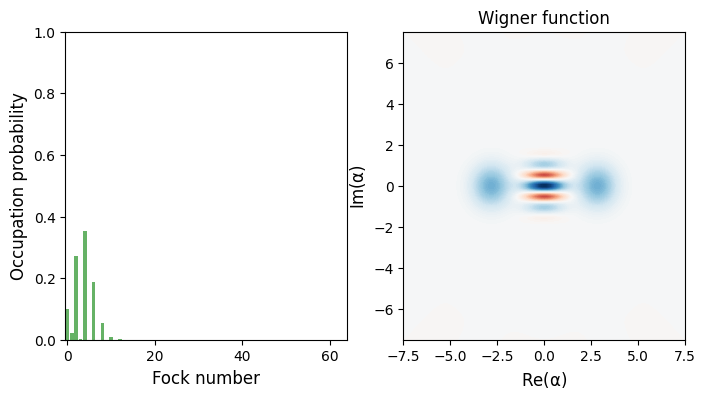

In [17]:
plot_wigner_fock_distribution(Qobj(rho))
plt.show()

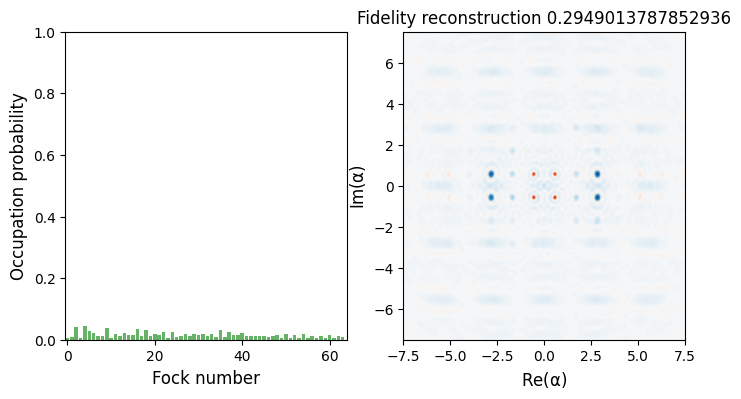

In [18]:
fig, ax = plot_wigner_fock_distribution(reconstruced)
plt.title("Fidelity reconstruction {}".format(fidelity(reconstruced, Qobj(rho))))
plt.show()